## <center> A 3d mesh generated from a SDF, representing  an image  extruded from a box </center>

Recently I discovered an interesting Python repository, **SDF** (**S**igned **D**istance **F**unction), [https://github.com/fogleman/sdf/](https://github.com/fogleman/sdf/), that
implements the generation of a 3D mesh from a given  SDF.
Among many examples, I'm excited by  the  method that  extrudes/carves a gray  image, from/into a box of small height.
Here, unlike the examples from the SDF repository, we are defining the gray image explicitly,
derive the mesh vertices and triangles to be plotted as a Plotly Mesh3d, and illustrate how the mesh looks like when the image is defined by its complement.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
from sdf import *

In [2]:
def Juliaset(z,c, maxiter=80):#maxiter= maximum number of allowed iterations  f^n(z), f(z)=z^2+c
    for n in range(maxiter):
        if  abs(z)>2:
            return n
        z = z*z + c    
    return maxiter

In [3]:
def sdf_img(path2img):
    #function derived from the sdf repo's folder, examples
    img = path2img    
    w, h = measure_image(img)
    f = rounded_box((w * 1.1, h * 1.1, 0.1), 0.05)
    f |= image(img).extrude(1) & slab(z0=0, z1=0.075)
    return f

Layout settings for the Plotly plot of the 3d mesh:

In [4]:
visible_off=dict(xaxis_visible=False,
                 yaxis_visible=False, zaxis_visible=False)
layt_image_save=dict(width=500, 
                     scene=dict(aspectmode="data", camera_eye=dict(x=2.65, y=-2.65, z=1.95), 
                                **visible_off),  
                     margin=dict(t=2, r=2, b=2, l=2))

Let us first create a gray image/heatmap (with a custom gray colormap), representing a Julia set, generated by the so called
Escape time algorithm:

In [5]:
colors =  [(0, 0, 0), (0.2, 0.2, 0.2), (1, 1, 1)] 
cmap = LinearSegmentedColormap.from_list('grayo', colors)

Generate a Julia set image with this colormap:

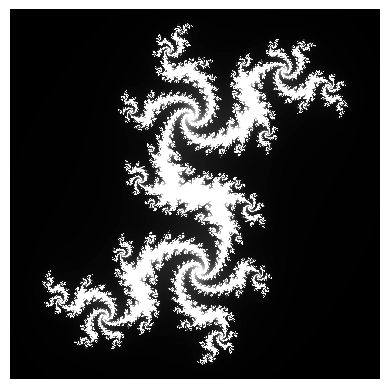

In [6]:
n = 1000
a = 1.25
x = np.linspace(-a, a, n)
x, y = np.meshgrid(x,x)
z = x + 1j*y
fig = plt.figure()
imarr = np.array([Juliaset(z[i,j], 0.300283+0.48857*1j) 
                      for i in range(n) for j in range(n)]).reshape(n, n)
plt.imshow(imarr, cmap=cmap,  interpolation='nearest')
plt.axis('off');

Save the  image:

In [ ]:
plt.imsave('images/juliaset.jpg', imarr, cmap=cmap)

In [ ]:
f = sdf_img('images/juliaset.jpg')
points = f.generate(step=None, bounds=None, samples=4194304, 
                    workers=8, batch_size=32, verbose=True, sparse=True)
print(f'Number of points: {len(points)}')

Extract the  isosurface triangulation, and the associated data to be plotted as a Plotly Mesh3d:

In [ ]:
verts, tri = np.unique(points, axis=0, return_inverse=True)
triangles = tri.reshape((-1,3) ) #the number of triangles is the number of points divided by 3
x, y, z = verts.T
I, J, K = triangles.T  

To save the resulted mesh  as an `obj`, `off`, `ply` or `stl`  file,  via `meshio`, we have to
define the meshio `cells`, as follows:

In [ ]:
import meshio
cells = [('triangle', triangles)]
msh = meshio.Mesh(verts, cells) 
msh.write("images/extruded-img.obj")

In [ ]:
fig = go.Figure(go.Mesh3d(x=x, y=y, z=z, 
                          i=I, j=J, k=K, intensity=z, 
                          cmin=z.min()+0.055, cmax=z.max(), 
                          colorscale="matter_r",
                          showscale=False,
                          lighting=dict(ambient=0.5,
                                        diffuse=1,
                                        fresnel=4,        
                                        specular=0.7,
                                        roughness=0.25),
                          lightposition=dict(x=100,
                                             y=100,
                                             z=1000)
                           ))

fig.update_layout(**layt_image_save)
fig.show()

![extruded-Julia-set](images/juliaset-exmesh.jpg)

When the Julia set is saved as its "complement", i.e.
`plt.imsave('images/juliasetrev.jpg', imarr.max()-imarr, cmap=cmap)`
then the corresponding image is:


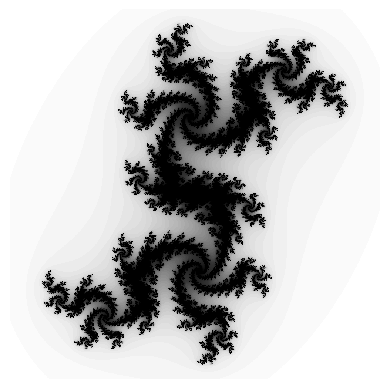

In [7]:
plt.imshow(imarr.max()-imarr, cmap=cmap,  interpolation='nearest')
plt.axis('off');

Calculating the corresponding SDF:
`f = sdf_img('images/juliasetrev.jpg')`
the associated 3d mesh illustrates a carved image in the box:

![carved Julia set](images/juliasetrev-mesh.jpg)

.

.